<center><h2>Gen AI: Vector Database</h2></center

In [ ]:
# Installation
# pip install chromadb==1.0.9
# pip install --upgrade huggingface_hub
# pip install --upgrade sentence-transformers

#### 5.1: ChromaDB Intro
- A vector database indexes and stores vector embeddings for fast retrieval and similarity search, with capabilities like CRUD operations, metadata filtering, horizontal scaling, and serverless. It efficient similarity searches across high-dimensional spaces.
- Vector embeddings are dense numerical arrays (vectors) that represent unstructured data like text, images, or audio in a high-dimensional space.
- Embeddings are generated by AI models (such as Large Language Models) and have many attributes or features, making their representation challenging to manage. In the context of AI and machine learning, these features represent different dimensions of the data that are essential for understanding patterns, relationships, and underlying structures. That is why we need a specialized database designed specifically for handling this data type.
- Role of vector db and its data flow
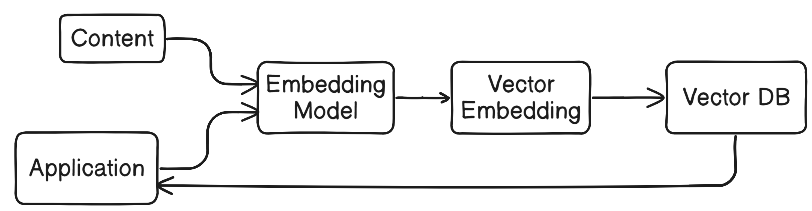
- How does a vector database work
  - Vectors -> Indexing -> Vector Database -> Query -> Post Processing
  - Indexing: The vector database indexes vectors using an algorithm such as PQ, LSH, or HNSW. This step maps the vectors to a data structure that will enable faster searching.
  - Querying: The vector database compares the indexed query vector to the indexed vectors in the dataset to find the nearest neighbors.
  - Post Processing: In some cases, the vector database retrieves the final nearest neighbors from the dataset and post-processes them to return the final results. This step can include re-ranking the nearest neighbors using a different similarity measure.
- Serverless Vector Databases
  - serverless vector database solves
    1. Separation of storage from compute: To optimize costs, compute should only be used when needed. That means decoupling the index storage from queries and searching only what is needed — this becomes increasingly difficult when involving latency.
    2. Multitenancy: Handling namespaces in indexes to ensure infrequently queried namespaces do not increase costs.
    3. Freshness: A vector DB needs to provide fresh data, meaning within a few seconds of inserting new data, it is queryable. Note, for Pinecone Serverless freshness can be delayed when inserting large amounts of data.
- With the Gen AI revolution, many vector databases have emerged. Here are a few popular ones: Chromadb (open source), Milvus (open source), Pinecone, Qdrant.
- Reference of above: What a vector database and how it works: https://www.pinecone.io/learn/vector-database/

#### Euclidean and Cosine Distance
- Euclidean distance measures the straight-line distance between two points in a vector space, reflecting absolute similarity.
- Cosine distance evaluates the angle between two vectors, focusing on their orientation rather than magnitude.
- Euclidean distance is sensitive to vector magnitude, while cosine distance emphasizes direction, making it ideal for text and document similarity.
- Choosing between Euclidean and cosine distance depends on the task — Euclidean for dense embeddings and cosine for sparse or high-dimensional data.
- Can metadata filtering in ChromaDB be combined with vector similarity searches: Yes, to refine search results based on both vector similarity and metadata attributes.
- How does metadata filtering improve the efficiency of vector searches in ChromaDB: By reducing the number of vectors to be compared during a search.
- In ChromaDB, what type of data does the database primarily store: vector embeddings and the associated metadata.
- Which of the following is a valid use case for ChromaDB: Building a recommendation system based on user embeddings. ChromaDB is a vector database designed to store and query embeddings efficiently. It’s ideal for use cases like: Semantic search, Recommendation systems, Retrieval-augmented, generation (RAG), Clustering and similarity-based tasks

#### 5.2: Basic Operations in ChromaDB

In [1]:
import chromadb

##### Ephemeral (In Memory) Client

In [2]:
client = chromadb.Client()

In [14]:
# We can use delete collection to delete it just in case you have created the news collection already in the memory
# client.delete_collection("news")

In [3]:
collection = client.create_collection(name="news")

# We can get the collection directly as a return value of create_collection method or
# call client.get_collection("news") later on to get it
# collection = client.get_collection("news")

In [4]:
collection.add(
    documents=[
        "Apple reported its quarterly earnings today.",
        "Apple has a lot of vitamin A" 
    ],
    ids=["id1", "id2"]
)

In [5]:
objects = collection.peek()
len(objects['embeddings'][0])

384

In [6]:
results = collection.query(
    query_texts=["New Iphone will launch in september"],
    n_results=2
)
results

{'ids': [['id1', 'id2']],
 'embeddings': None,
 'documents': [['Apple reported its quarterly earnings today.',
   'Apple has a lot of vitamin A']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[None, None]],
 'distances': [[1.3853877782821655, 1.7049835920333862]]}

In [7]:
results = collection.query(
    query_texts = ["My niece loves oranges"],
    n_results=2
)
results

{'ids': [['id2', 'id1']],
 'embeddings': None,
 'documents': [['Apple has a lot of vitamin A',
   'Apple reported its quarterly earnings today.']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[None, None]],
 'distances': [[1.4487004280090332, 1.8779758214950562]]}

##### Persistent Client

In [ ]:
clientp = chromadb.PersistentClient(path=".././news_vector_db")

In [ ]:
from chromadb.utils import embedding_functions

ef = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name='all-distilroberta-v1'
)

collection = clientp.create_collection(
    name="news_v2",
    embedding_function=ef
)

In [ ]:
collection.add(
    documents = [
        "Apple reported its quarterly earnings today.",
        "Apple has a lot of vitamin A"
    ],
    ids = ["id1", "id2"]
)

In [23]:
results = collection.query(
    query_texts = ["New iPhone will launch this September"],
    n_results=2
)
results

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


{'ids': [['id1', 'id2']],
 'distances': [[1.3624801497380787, 1.618443419359539]],
 'metadatas': [[None, None]],
 'embeddings': None,
 'documents': [['Apple reported its quarterly earnings today.',
   'Apple has a lot of vitamin A']],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

In [24]:
clientp.heartbeat()

1754463229388121100

In [ ]:
# client reset will empty and delete the database. By default you can not perform
# this operation. You need to set a specific environment variable to allow the reset 
# as it is a destructive operation
# client.reset()

#### 5.3: Add, Update, Delete Query

In [ ]:
from datetime import datetime

collection = client.create_collection(
    name="reviews", 
#     embedding_function=emb_fn,
    metadata={
        "description": "Product reviews",
        "created": str(datetime.now())
    }  
)

In [26]:
# get collection gets a collection object. If collection doesn't exist then it throws an error
collection = client.get_collection("reviews")

In [ ]:
# Add
# 1. Add Initial Customer Feedback
collection.add(
    documents=[
        "The delivery was fast and the product quality is excellent!",
        "I was not able to increase TV's brightness so I returned it back",
        "The shoes I ordered were too small. Sizing is inaccurate.",
        "Great customer support. Resolved my issue in minutes."
    ],
    ids=["r1", "r2", "r3", "r4"],
    metadatas=[
        {"product_category": "electronics", "rating": 5},
        {"product_category": "electronics", "rating": 2},
        {"product_category": "apparel", "rating": 3},
        {"product_category": "services", "rating": 4}
    ]
)

In [28]:
collection.count()

4

In [ ]:
# returns all the documents in a collection
collection.peek()

In [30]:
collection.get(ids=['r1','r2'])

Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given


{'ids': ['r1', 'r2'],
 'embeddings': None,
 'metadatas': [{'product_category': 'electronics', 'rating': 5},
  {'product_category': 'electronics', 'rating': 2}],
 'documents': ['The delivery was fast and the product quality is excellent!',
  "I was not able to increase TV's brightness so I returned it back"],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents']}

In [31]:
collection.query(
    query_texts = ["fast shipping"],
    n_results=2,
    where={"product_category": "electronics"}
)

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


{'ids': [['r1', 'r2']],
 'distances': [[0.8920919895172119, 2.0018961429595947]],
 'metadatas': [[{'product_category': 'electronics', 'rating': 5},
   {'product_category': 'electronics', 'rating': 2}]],
 'embeddings': None,
 'documents': [['The delivery was fast and the product quality is excellent!',
   "I was not able to increase TV's brightness so I returned it back"]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

In [ ]:
# Update
collection.update(
    documents=["The shoes I ordered were replaced with a larger size. Fits perfectly now!"],
    ids=["r3"],
    metadatas=[
        {"product_category": "apparel", "rating": 5}  # Rating improved after resolution
    ]
)

In [33]:
# Query Again to Verify Update
query_results = collection.query(
    query_texts=["shoes size"],
    n_results=2,
    where={"product_category": "apparel"}
)
query_results

{'ids': [['r3']],
 'distances': [[0.6437577605247498]],
 'metadatas': [[{'product_category': 'apparel', 'rating': 5}]],
 'embeddings': None,
 'documents': [['The shoes I ordered were replaced with a larger size. Fits perfectly now!']],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

In [ ]:
# Delete Records
collection.delete(ids=["r1","r2","r3"])

In [35]:
# Delete Collection
client.delete_collection(name='reviews')

#### 5.4: Metadata Filtering

In [36]:
from datetime import datetime

collection = client.create_collection(
    name="reviews", 
    metadata={
        "description": "Product reviews",
        "created": str(datetime.now())
    }  
)

Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [37]:
collection.add(
    documents=[
        "The delivery was fast and the product quality is excellent!",
        "I was not able to increase TV's brightness so I returned it back",
        "The shoes I ordered were too small. Sizing is inaccurate.",
        "Great customer support. Resolved my issue in minutes."
    ],
    ids=["r1", "r2", "r3", "r4"],
    metadatas=[
        {"product_category": "electronics", "rating": 5},
        {"product_category": "electronics", "rating": 2},
        {"product_category": "apparel", "rating": 3},
        {"product_category": "services", "rating": 4}
    ]
)

Failed to send telemetry event CollectionAddEvent: capture() takes 1 positional argument but 3 were given


In [38]:
# Metadata Filtering
collection.query(
    query_texts=["fast shipping"],
    n_results=2,
    where={"product_category": "electronics"}
)

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


{'ids': [['r1', 'r2']],
 'distances': [[0.8920919895172119, 2.0018961429595947]],
 'metadatas': [[{'product_category': 'electronics', 'rating': 5},
   {'product_category': 'electronics', 'rating': 2}]],
 'embeddings': None,
 'documents': [['The delivery was fast and the product quality is excellent!',
   "I was not able to increase TV's brightness so I returned it back"]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

In [39]:
collection.query(
    query_texts=["fast shipping"],
    n_results=2,
    where={"rating": { "$in": [1,2,3] }}
)

{'ids': [['r3', 'r2']],
 'distances': [[1.7524369955062866, 2.0018961429595947]],
 'metadatas': [[{'product_category': 'apparel', 'rating': 3},
   {'product_category': 'electronics', 'rating': 2}]],
 'embeddings': None,
 'documents': [['The shoes I ordered were too small. Sizing is inaccurate.',
   "I was not able to increase TV's brightness so I returned it back"]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

In [40]:
# Full Text Search using where_document parameter
collection.query(
    query_texts=["fast shipping"],
    n_results=2,
    where_document={ "$contains": "customer"}
)

{'ids': [['r4']],
 'distances': [[1.7052761316299438]],
 'metadatas': [[{'product_category': 'services', 'rating': 4}]],
 'embeddings': None,
 'documents': [['Great customer support. Resolved my issue in minutes.']],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

In [ ]:
# include parameter
collection.query(
    query_texts=["fast shipping"],
    n_results=2,
    where_document={ "$contains": "customer"},
    include=["embeddings"]
)